# Optimizing & monochromatizing H41 ($\lambda_{\mathrm{laser}}=1030~\mathrm{nm}$) in Ar for Gaussian jets

This notebook is a modification of `optimise_ar_1030nm_H41_in_theta.ipynb`. The difference is that we consider here Gaussian shape of the gas jets. THe optimization is then done numerically.

In [1]:
# general imports
import copy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Latex
# imports for analytical
import XUV_refractive_index as XUV_index
import XUV_signal_computation2 as XUV_sig
import mynumerics as mn
import harmonic_signal as hs

['Ar_Henke', 'Ar_NIST', 'He_Henke', 'He_NIST', 'Kr_Henke', 'Kr_NIST', 'Ne_Henke', 'Ne_NIST', 'Xe_Henke', 'Xe_NIST']


# Optimisation goal & initial parameters

Our goal is to optimise the absorption-limited monochromatisation of the 41st harmonic in Argon generated by a 1030-nm laser. The dependence of the absorption length in this region is

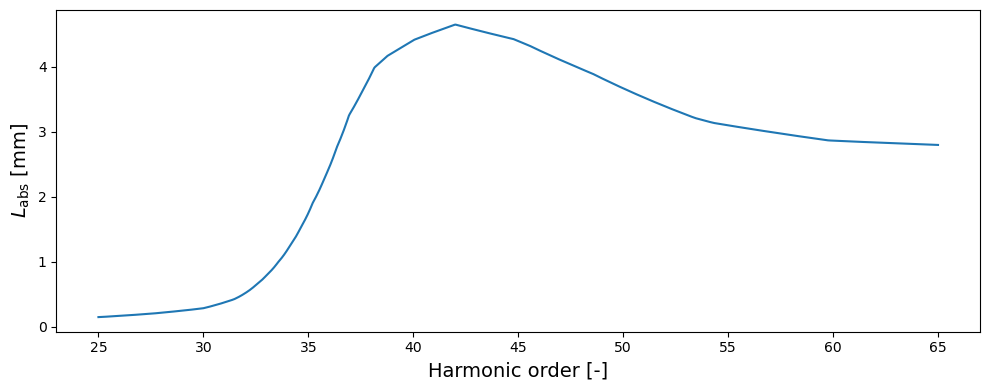

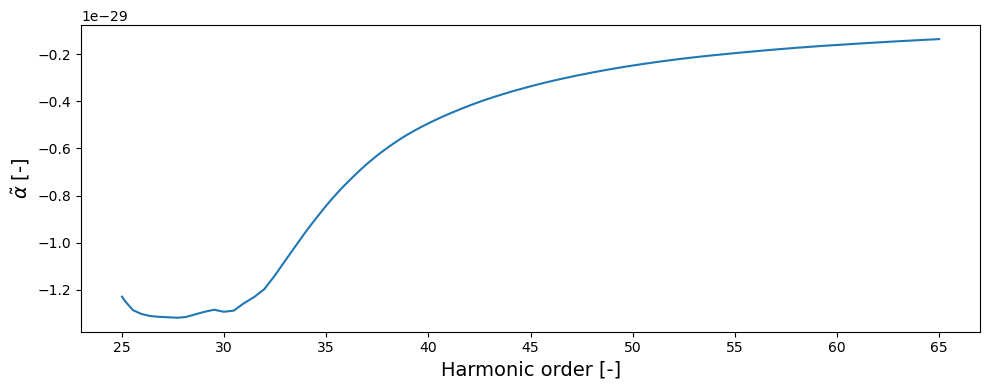

In [2]:
gas_type = 'Ar'
XUV_table_type_absorption = 'Henke' # {Henke, NIST}    
XUV_table_type_dispersion = 'Henke'
H_opt = 41

# laser  
omegaSI = mn.ConvertPhoton(1030e-9, 'lambdaSI', 'omegaSI') 
pressure = 100e-3


parameters = {'XUV_table_type_dispersion': XUV_table_type_dispersion,
              'XUV_table_type_absorption': XUV_table_type_absorption,
              'gas_type': gas_type,
              'omegaSI': omegaSI,
              'Aq' : 1.0}


def asymptotic_signal(p,omega):
    return 4.*((p*parameters['Aq'])**2)*XUV_index.L_abs(omega, pressure, gas_type + '_' + XUV_table_type_absorption)**2


Hgrid_plot = np.linspace(25,65,1000)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Harmonic order [-]", fontsize=14)
ax.set_ylabel("$L_{\mathrm{abs}}$ [mm]", fontsize=14)

ax.plot(Hgrid_plot, 1e3*XUV_index.L_abs(Hgrid_plot*omegaSI, pressure, gas_type + '_' + XUV_table_type_absorption)) #, color="b", alpha=0.5, label="q + 2")

plt.tight_layout()
fig.savefig('Labs.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Harmonic order [-]", fontsize=14)
ax.set_ylabel(r"$\tilde{\alpha}$ [-]", fontsize=14)

ax.plot(Hgrid_plot, XUV_index.polarisability(Hgrid_plot*omegaSI, gas_type + '_' + XUV_table_type_dispersion)) #, color="b", alpha=0.5, label="q + 2")

plt.tight_layout()
# fig.savefig('Labs.pdf')
plt.show()

# Contrast as a function of the number of periods while keeping the total length of the medium $3L_{\mathrm{abs}}$

To find the optimising parameters, we use a sample series of sample $l_1=1~\mathrm{mm}$. We investigate the signals and the contrast with the increasing number of periods. We impose the condition that the total length of the gas is $3L_{\mathrm{abs}}$.

c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  L_coh = np.abs(np.pi/delta_k1)


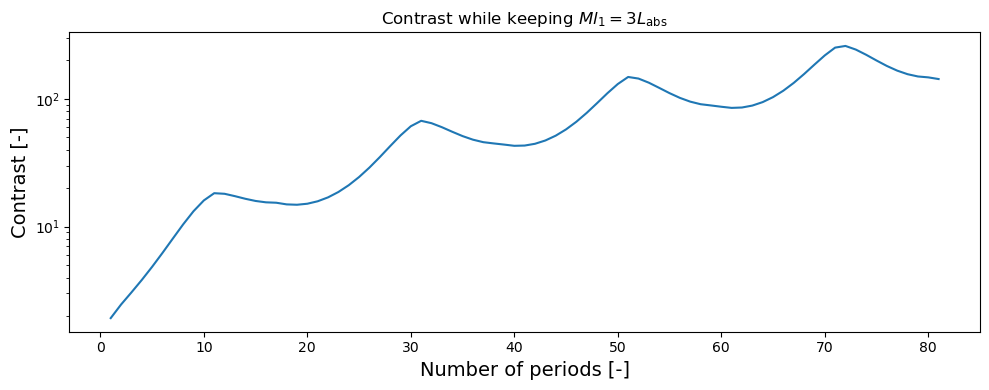

In [3]:
l1=1e-3
pressure_guess = 10e-3
L_abs_factor = 3.
delta_phi = np.pi/H_opt

# H_list = list(np.arange(23,66,2))
M_max = 2*H_opt

M_grid = np.arange(1, M_max)

# find optimal parameters of the generation
eta_opt = XUV_sig.eta_opt(H_opt, parameters)
eta_gen = 0.25*eta_opt # 0.0 # 0.5*eta_opt


H_interest = list(range(H_opt-6,H_opt+7,2)) # list(range(H_opt-24,H_opt+25,2)) # list(range(H_opt-6,H_opt+7,2))
H_compare = copy.deepcopy(H_interest)
H_compare.remove(H_opt)

pressure_grid = np.zeros((len(M_grid),))
zeta_opt = np.empty((len(M_grid),)); xi_opt = np.empty((len(M_grid),))
signal_list = []
contrasts = np.zeros((len(M_grid),))

for k1 in range(len(M_grid)):
    L_abs_p_f = lambda p: M_grid[k1]*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
    pressure_grid[k1] = sp.optimize.newton(L_abs_p_f, pressure_guess)
    # print(3*XUV_char.L_abs(gas_type + '_' + XUV_table_type_absorption, Horder_init*omegaSI, pressure_grid[k1]))
    zeta_opt[k1] = XUV_sig.zeta_single_segment(pressure_grid[k1], H_opt, eta_gen, parameters)
    xi_opt[k1] = XUV_sig.xi_calc_pm(delta_phi,pressure_grid[k1], l1, zeta_opt[k1], eta_gen, H_opt, parameters)
    signal_list.append(
        [XUV_sig.periodic_medium_signal(pressure_grid[k1], zeta_opt[k1], l1, xi_opt[k1], eta_gen, H_calc, M_grid[k1], parameters)[1] for H_calc in H_interest]
        )
    
    contrasts[k1] = XUV_sig.monochrom_function(H_interest, signal_list[k1], H_opt, H_compare, metric='max')

signals = np.asarray(signal_list)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, contrasts)

ax.set_title(r'Contrast while keeping $Ml_1 = 3L_{\mathrm{abs}}$') 

plt.tight_layout()
fig.savefig('Contrast_keeping_3Labs.pdf')
plt.show()


This result shows that we reach the contrast around 20 for 11 periods.

# Detailed study of the signal for 11 periods

Using the previous result, we investigate the generation scheme for 11 periods. We show the signals of the harmonics of the interest, the evolution of the contrast with the number of periods. For a comparison, we show also signals & contrasts for halving $l_1$ (with keeping the pressure constant) and doubling the phase jump.

zeta=2.8938795623335128e-05
xi=0.8681063146682866
zeta2=2.8938795623335128e-05
xi2=1.7362126293365736
zeta3=2.8938795623335128e-05
xi3=1.7362126293365736


c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  L_coh = np.abs(np.pi/delta_k1)


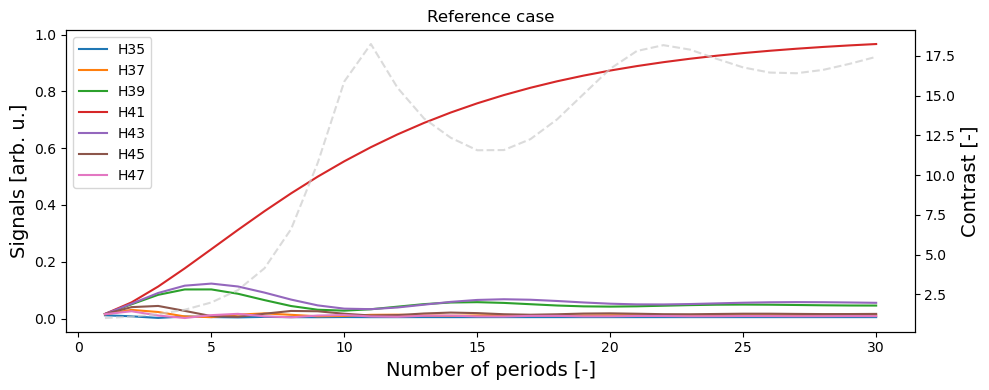

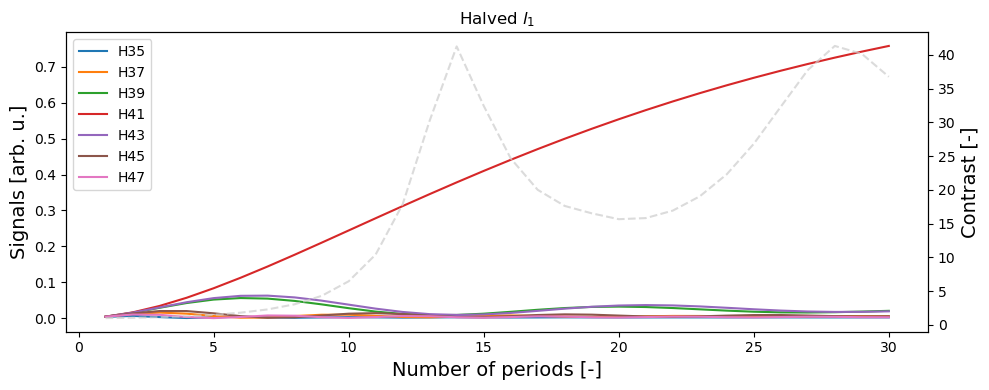

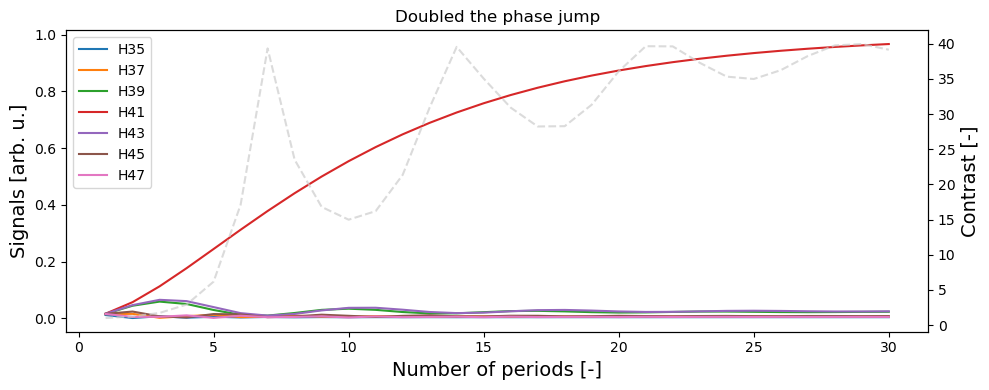

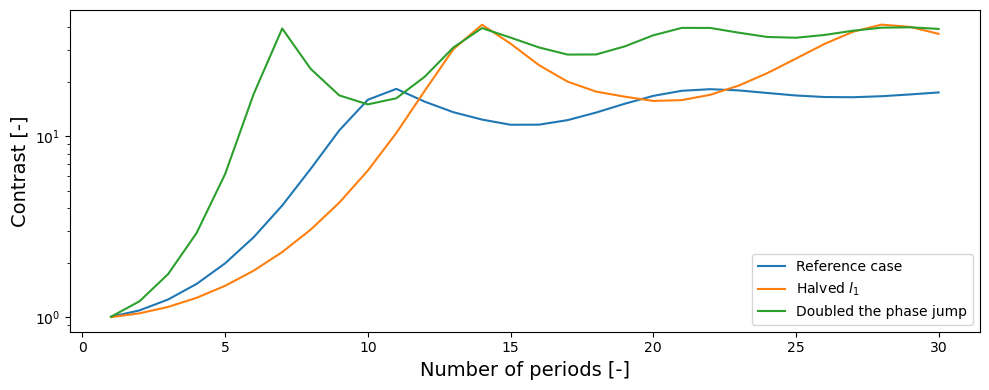

In [4]:
M_3Labs = 11
M_grid = np.arange(1, 31)

L_abs_p_f = lambda p: M_3Labs*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
pressure = sp.optimize.newton(L_abs_p_f, pressure_guess)

zeta_opt = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt = XUV_sig.xi_calc_pm(delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta='+str(zeta_opt))
print('xi='+str(xi_opt))

# halving pressure
zeta_opt2 = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt2 = XUV_sig.xi_calc_pm(delta_phi,pressure, 0.5*l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta2='+str(zeta_opt2))
print('xi2='+str(xi_opt2))

# doubling the jump
zeta_opt3 = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt3 = XUV_sig.xi_calc_pm(2.*delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta3='+str(zeta_opt3))
print('xi3='+str(xi_opt3))

# signals
signal_list = [XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]
signal_list2 = [XUV_sig.periodic_medium_signal(pressure, zeta_opt2, 0.5*l1, xi_opt2, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]
signal_list3 = [XUV_sig.periodic_medium_signal(pressure, zeta_opt3, l1, xi_opt3, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]


# plot signals
sig_norm = asymptotic_signal(pressure,H_opt*omegaSI)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()
ax.set_title("Reference case")

plt.tight_layout()
fig.savefig('Reference_case.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list2[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list2, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()

ax.set_title(r"Halved $l_1$")

plt.tight_layout()
fig.savefig('l1_halved.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list3[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list3, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()
ax.set_title("Doubled the phase jump")

plt.tight_layout()
fig.savefig('Phase-jump_doubled.pdf')
plt.show()


# contrasts
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list, H_opt, H_compare, metric='max'), label = 'Reference case')
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list2, H_opt, H_compare, metric='max'), label = r"Halved $l_1$")
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list3, H_opt, H_compare, metric='max'), label = "Doubled the phase jump")
plt.legend()

plt.tight_layout()
fig.savefig('Contrasts_comparisons.pdf')
plt.show()



These results provided further insight in the bould-up of the signal & contrast in the case of our interest. In particular, we show the effects of halving the gas-jet length and doubling the phase-jump. These conclusion are inferred from a comparison with the reference case:
1) If we use halved $l_1$, both signal and the contrast grow slower with increasing the number of periods. However the asymptotic contrast is higher that in the reference case. It shows that if the setup allows for adding more jets, the resulting scheme provides a better contrast. We observe also that the slower growth of the contrast is caused by the larger number of periods needed to suppress the signal of the neighbouring harmonics. This conclusion is consistent with the fact, that the absorption within a single jet becomes weaker and we are closer to the analytic study neglecting the absorption.
2) If we double the phase-jump, we obtain the same signal for the optimised harmonic after a fixed number of periods. Furthermore, the build-up of the contrast is much faster as the neighbouring harmonics are suppressed faster as functions of the number of periods. Finally, the asymptotic contrast is the same as in the case with the halved $l_1$, which is consistent with the analytic derivation.

Furthemore, $\zeta$ is the same for all these regimes. The only difference is in $\xi$. Since the optimising condition for $\xi$ scales with the ratio $\Delta \phi / l_1$ (where $\Delta \phi$ is the phase-jump), we have the same values of $\xi$ for either halving $l_1$ or doubling $\Delta \phi$.



# Gaussian train
## Description of gas profile
We have investigated the optimal design using an idealised step-like medium. This design was reached by using analytically computed values of $\zeta$ and $\xi$. We may be interested, how this design is affected by using a realistic density profile. We present here a train of Gaussian jets, defined by $G(z) = p_G\exp(-((z-z_i)/a)^2)$, where $z_i$ denotes their positions. The function defining this shape is:

In [5]:
# Gaussian train
def Gaussian_train(zgrid_, p_max_, a_, positions_):
    res = p_max_ * np.exp(-((zgrid_-positions_[0])/a_)**2)
    for position in positions_[1:]:  res += p_max_ * np.exp(-((zgrid_-position)/a_)**2)
    return res

We select their shape to match the optical thickness of the idelaised medium, i.e. $\int_{-\infty}^{\infty} G(z) \mathrm{d}z = p_G\sqrt{\pi}a=l_1 p_I$. Hence, $a=l_1 p_I/(p_G \sqrt{\pi})$. Hereafter we use the `scale_factor`$=p_I/p_G$. We set now its value and find the appropriate $a$,

In [6]:
scale_factor = 2. #scale Gaussian peak pressure
a_Gauss = l1/(scale_factor*np.sqrt(np.pi)) # to preserve total optical path

## Optimisation procedure
Now, we apply the optimisation procedure. The only difference in this case is then that $\zeta$ and $\xi$ are find by a numerical procedure. Since it is the problem of two consecutive optimisations of one function of a single variable, we use the simple routine `sp.optimize.fmin`. Here is the code accomplishing the task.

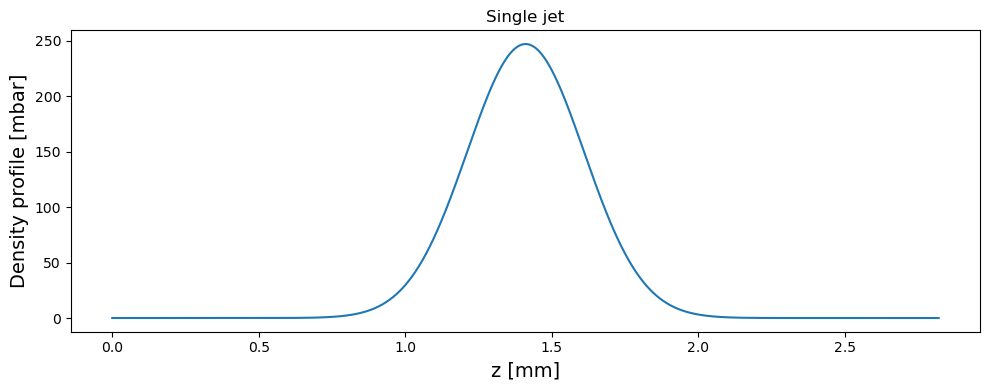

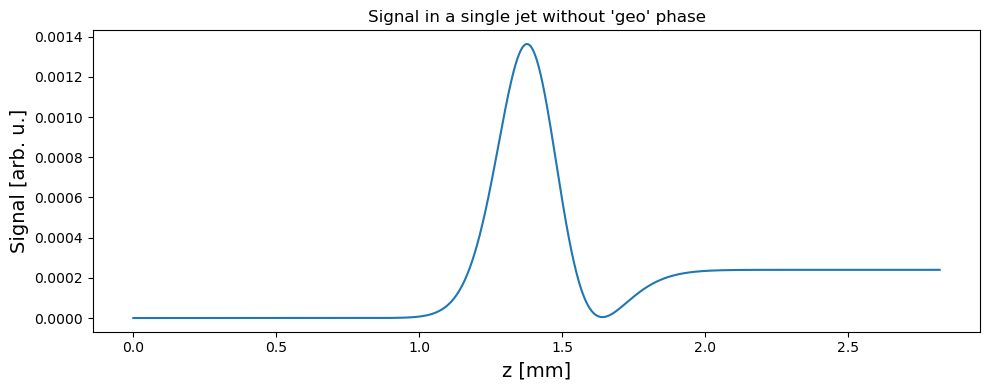

Optimization terminated successfully.
         Current function value: -0.013810
         Iterations: 25
         Function evaluations: 50
The optimal value of 'geo' is [258.1842041]


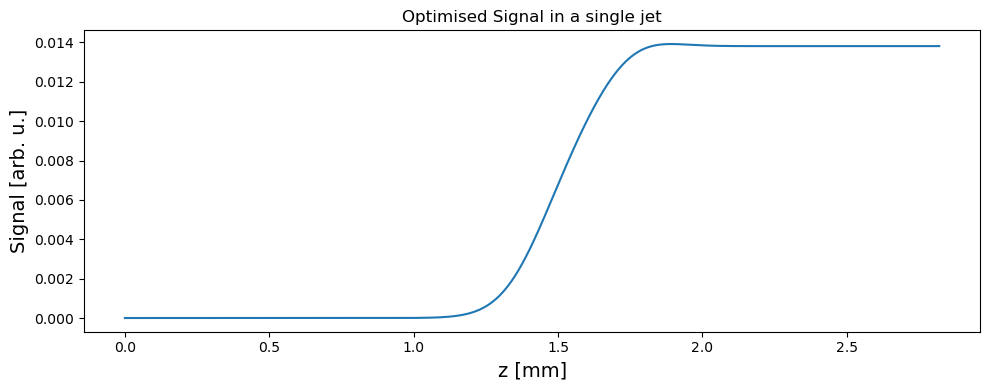

In [7]:
# First, we optimise the generation within a single Gaussian 'jet'

dz = 1e-6
zgrid = np.ogrid[0:10*a_Gauss:dz] # grid used for the integration

pressure_profile = Gaussian_train(zgrid, scale_factor*pressure, a_Gauss, [5*a_Gauss])

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid, 1e3*pressure_profile)
ax.set_title("Single jet")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Density profile [mbar]", fontsize=14)
plt.tight_layout()
plt.show()

# NOTE: we still normalise by 'asymptotic_signal(pressure,H_opt*omegaSI))', because we keep the reference step-like profile
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid, hs.hh_signal_dk(zgrid,
                        pressure_profile,
                        'Ar',
                        eta_gen,
                        mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                        H_opt,
                        0,
                        parameters)/asymptotic_signal(pressure,H_opt*omegaSI))
ax.set_title("Signal in a single jet without 'geo' phase")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Signal [arb. u.]", fontsize=14)
plt.tight_layout()
plt.show()


### THE OPTIMISATION PROCEDURE
geo_opt = sp.optimize.fmin(lambda geo: -hs.hh_signal_dk(zgrid,
                                            pressure_profile,
                                            'Ar',
                                            eta_gen,
                                            mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                            H_opt,
                                            geo,
                                            parameters)[-1]/asymptotic_signal(pressure,H_opt*omegaSI),
                                            100) # it might fall in a local maximum for initial guess 0
print("The optimal value of 'geo' is",geo_opt)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid, hs.hh_signal_dk(zgrid,
                        pressure_profile,
                        'Ar',
                        eta_gen,
                        mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                        H_opt,
                        geo_opt,
                        parameters)/asymptotic_signal(pressure,H_opt*omegaSI))
ax.set_title("Optimised Signal in a single jet")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Signal [arb. u.]", fontsize=14)
plt.tight_layout()
plt.show()


Next, we find the optimal period for the monochromatisation. The Gaussian jets are spaced by `stride`.

Optimization terminated successfully.
         Current function value: -0.516346
         Iterations: 10
         Function evaluations: 20
The optimal stride is [1.27118966]  mm


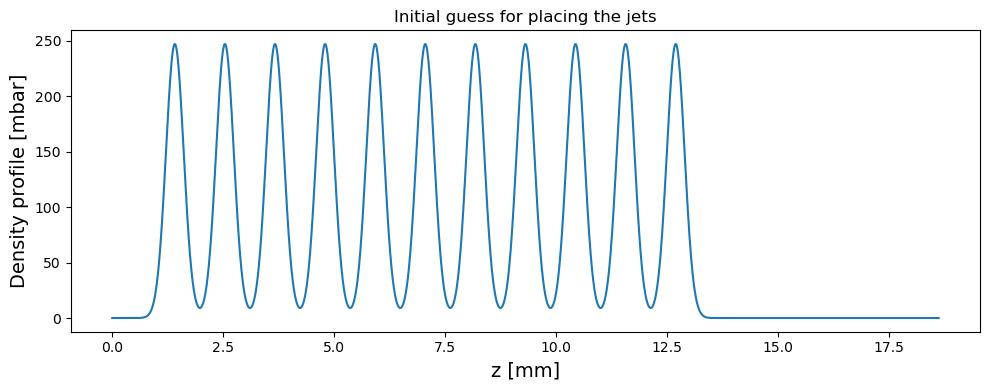

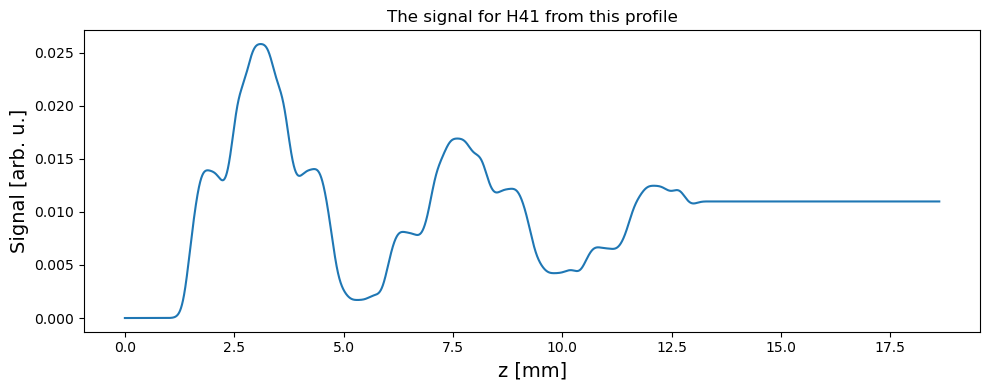

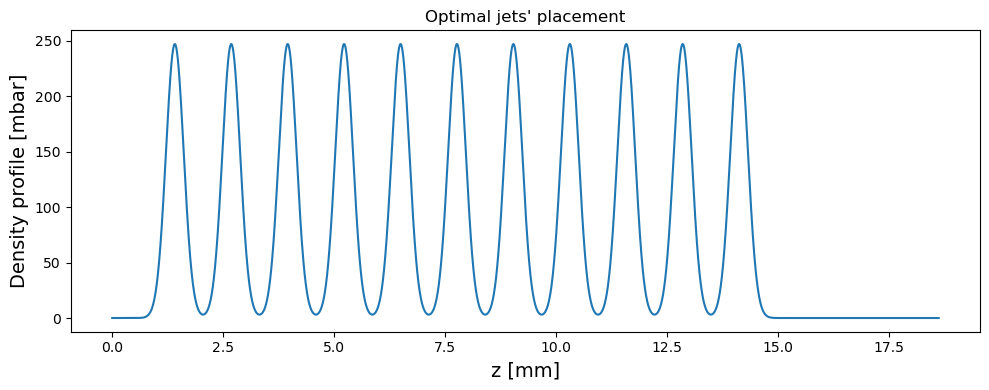

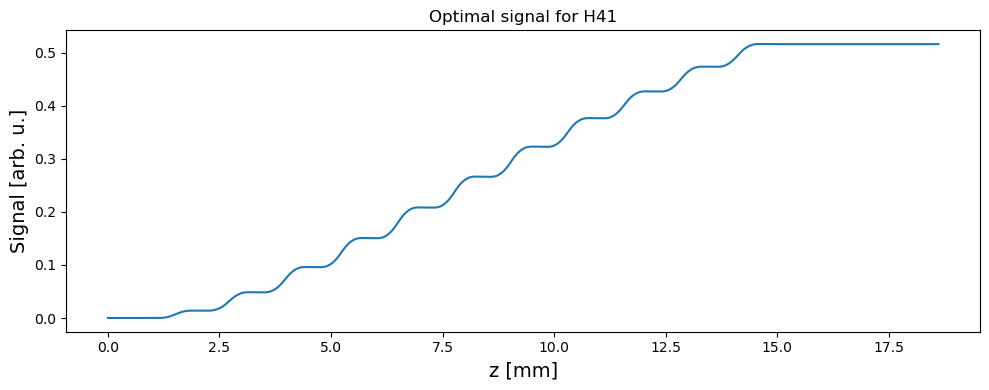

c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:519: RuntimeWarning: invalid value encountered in divide
  return signals[Hlist.index(H_sel)]/signals_slice_max


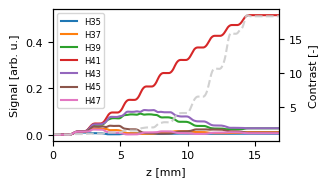

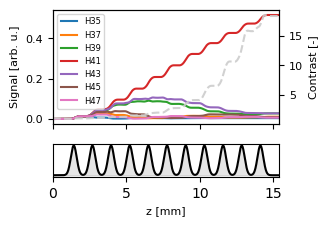

In [8]:
def Gauss_train_stride(zgrid_, p_max_, a_, pos0_, stride_, N_jets_): # the defining parameters of the train are now the position of the first jet and the 'stride'
    return Gaussian_train(zgrid_, p_max_, a_, [pos0_ + k1*stride_ for k1 in range(N_jets_)])

zgrid2 = np.ogrid[0:6*M_3Labs*a_Gauss:dz] # longer grid to support the jets, values are found to accommodate the jets


# THE OPTIMISATION PROCEDURE
stride_opt = sp.optimize.fmin(lambda stride: -hs.hh_signal_dk(zgrid2,
                                                Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride, M_3Labs),
                                                'Ar',
                                                eta_gen,
                                                mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                                H_opt,
                                                geo_opt,
                                                parameters)[-1]/asymptotic_signal(pressure,H_opt*omegaSI),
                              4*a_Gauss)
print("The optimal stride is", 1e3*stride_opt, " mm")



fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid2, 1e3*Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, 4*a_Gauss, M_3Labs))
ax.set_title("Initial guess for placing the jets")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Density profile [mbar]", fontsize=14)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid2, hs.hh_signal_dk(zgrid2,
                                            Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, 4*a_Gauss, M_3Labs),
                                            'Ar',
                                            eta_gen,
                                            mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                            H_opt,
                                            geo_opt,
                                            parameters)/asymptotic_signal(pressure,H_opt*omegaSI)
                                            )
ax.set_title("The signal for H"+str(H_opt)+" from this profile")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Signal [arb. u.]", fontsize=14)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid2, 1e3*Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs))
ax.set_title("Optimal jets' placement")
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Density profile [mbar]", fontsize=14)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
ax.plot(1e3*zgrid2, hs.hh_signal_dk(zgrid2,
                                            Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                            'Ar',
                                            eta_gen,
                                            mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                            H_opt,
                                            geo_opt,
                                            parameters)/asymptotic_signal(pressure,H_opt*omegaSI)
                                            )
ax.set_title("Optimal signal for H"+str(H_opt))
ax.set_xlabel("z [mm]", fontsize=14)
ax.set_ylabel("Signal [arb. u.]", fontsize=14)
plt.tight_layout()
plt.show()


cm = 1/2.54  # centimeters in inches
scale = 1
figsize = (scale*8.6*cm, scale*5*cm)
fontsize = 8

fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel("z [mm]", fontsize=fontsize)
ax.set_ylabel("Signals [arb. u.]", fontsize=fontsize)
for k1 in range(len(H_interest)):
    ax.plot(1e3*zgrid2, hs.hh_signal_dk(zgrid2,
                                            Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                            'Ar',
                                            eta_gen,
                                            mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                            H_interest[k1],
                                            geo_opt,
                                            parameters)/asymptotic_signal(pressure,H_opt*omegaSI)
                                            , label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=fontsize)
ax_right.plot(1e3*zgrid2, XUV_sig.monochrom_function(H_interest,
                                                    [hs.hh_signal_dk(zgrid2,
                                                        Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                                        'Ar',
                                                        eta_gen,
                                                        mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                                        H_foo,
                                                        geo_opt,
                                                        parameters) for H_foo in H_interest],
                                                    H_opt,
                                                    H_compare,
                                                    metric='max'), color='0.8', linestyle='--', alpha=0.9)

# ax.set_title("Different harmonics + contrast")
ax.set_xlabel("z [mm]", fontsize=fontsize)
ax.set_ylabel("Signal [arb. u.]", fontsize=fontsize)
ax.set_xlim(0, 1e3*(M_3Labs*stride_opt + 10*a_Gauss)) # adjust xaxis to fit nicely the optimised solution
ax.tick_params(axis="both", labelsize=fontsize)
ax_right.tick_params(axis="both", labelsize=fontsize)

ax.legend(fontsize=fontsize-2)
# ax.set_title("Reference case")

plt.tight_layout()
# fig.savefig('Reference_case.pdf')
plt.savefig("fig8_5.png", dpi=600)
plt.show()

### enhanced figure

cm = 1/2.54  # centimeters in inches
scale = 1
figsize = (scale*8.6*cm, scale*6*cm)
fontsize = 8

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={"height_ratios": [3.5, 1]}, sharex=True) # plt.subplots(figsize=figsize)
ax[1].set_xlabel("z [mm]", fontsize=fontsize)
ax[0].set_ylabel("Signals [arb. u.]", fontsize=fontsize)
for k1 in range(len(H_interest)):
    ax[0].plot(1e3*zgrid2, hs.hh_signal_dk(zgrid2,
                                            Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                            'Ar',
                                            eta_gen,
                                            mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                            H_interest[k1],
                                            geo_opt,
                                            parameters)/asymptotic_signal(pressure,H_opt*omegaSI)
                                            , label= r"H"+str(H_interest[k1]))

ax_right = ax[0].twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=fontsize)
ax_right.plot(1e3*zgrid2, XUV_sig.monochrom_function(H_interest,
                                                    [hs.hh_signal_dk(zgrid2,
                                                        Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                                        'Ar',
                                                        eta_gen,
                                                        mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                                        H_foo,
                                                        geo_opt,
                                                        parameters) for H_foo in H_interest],
                                                    H_opt,
                                                    H_compare,
                                                    metric='max'), color='0.8', linestyle='--', alpha=0.9)

# ax.set_title("Different harmonics + contrast")
ax[1].set_xlabel("z [mm]", fontsize=fontsize)
ax[0].set_ylabel("Signal [arb. u.]", fontsize=fontsize)
ax[1].set_xlim(0, 1e3*(M_3Labs*stride_opt + 5*a_Gauss)) # adjust xaxis to fit nicely the optimised solution
ax[0].tick_params(axis="both", labelsize=fontsize)
ax_right.tick_params(axis="both", labelsize=fontsize)

ax[0].legend(fontsize=fontsize-2)
# ax.set_title("Reference case")

ax[1].set_yticks([])
ax[1].plot(1e3*zgrid2, 1e3*Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs), color="k", linestyle="-")
ax[1].fill_between(1e3*zgrid2, 1e3*Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs), alpha=0.1, color="k")

plt.tight_layout()
# fig.savefig('Reference_case.pdf')
plt.savefig("fig9.png", dpi=600)
plt.show()

Finally, we compare the signals from the binary medium and the Gaussian jets after 11 periods for the optimal cases:

In [9]:
signal_binary = signal_list[H_interest.index(H_opt)][10]/asymptotic_signal(pressure,H_opt*omegaSI)
signal_Gauss = hs.hh_signal_dk(
                                        zgrid2,
                                        Gauss_train_stride(zgrid2, scale_factor*pressure, a_Gauss, 5*a_Gauss, stride_opt, M_3Labs),
                                        'Ar',
                                        eta_gen,
                                        mn.ConvertPhoton(omegaSI, 'omegaSI', 'lambdaSI'),
                                        H_opt,
                                        geo_opt,
                                        parameters)[-1]/asymptotic_signal(pressure,H_opt*omegaSI)

print('binary medium',signal_binary, 'arb.u.')
print('Gaussian jets',signal_Gauss, 'arb.u.')
print('relative difference', 100*abs(signal_binary-signal_Gauss)/signal_binary,'%')

binary medium 0.6035267480709977 arb.u.
Gaussian jets 0.5163459386326331 arb.u.
relative difference 14.44522711164225 %
